In [ ]:

from matplotlib import pyplot
import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from numpy import *

import numpy as np
from numpy import mean
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from numpy.random import seed

from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot

import pandas as pd  
from pandas import read_csv

import pygam
from pygam import ExpectileGAM
from pygam import LinearGAM
from pygam import LogisticGAM
from pygam.datasets import mcycle

from random import randint
from random import random
from random import seed

import seaborn as sns

import scipy
from scipy import stats # For in-built method to get PCC

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import sklearn
#from sklearn.datasets import load_breast_cancer
import sklearn.linear_model
from sklearn import linear_model
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RepeatedKFold, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *

import statsmodels.api as sm
import statsmodels.tools
from statsmodels.stats.outliers_influence import OLSInfluence

from tqdm import tnrange, tqdm_notebook
#from zca import zca

import itertools
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import pandas as pd
import pingouin as pg

import random

import sys

#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

import warnings
warnings.filterwarnings('ignore')

from dask.distributed import Client
from dask.distributed import as_completed

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface

"""

from __future__ import division

import numpy as np
from scipy import linalg

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_


In [ ]:
#np.array(X.iloc[:, 0:])

In [ ]:

df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')

target = "Poverty"
y = df[[target]]
X = df.loc[:, ~df.columns.isin(["States",target])].copy()

df.describe()

In [115]:
from tqdm import tnrange, tqdm_notebook

#inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
#outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

k_=10

cv_outer = KFold(n_splits=k_, shuffle=True, random_state=1)
cv_inner = KFold(n_splits=k_, shuffle=True, random_state=1)

#Initialization variables

k = len(X.columns)

terms = list()
#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        terms.append(list(combo))
        

Loop...:   0%|          | 0/9 [00:00<?, ?it/s]

In [116]:

def process_term(npa_):
    t=npa_[0]
    X=npa_[1]
    y=npa_[2]
    
    #print(t)

    #print(t)
    subX = X[t]
    
    outer_results = list()
    
    for trainv_ix, test_ix in cv_outer.split(subX):
        # split data
        X_trainv, X_test = subX.iloc[trainv_ix], subX.iloc[test_ix, :]
        y_trainv, y_test = y.iloc[trainv_ix], y.iloc[test_ix]

        inner_results = list()
        inner_models = list()
        
        #good juncture to fork locally
        for train_ix, valid_ix in cv_inner.split(X_trainv):
            # split data
            X_train, X_valid = X_trainv.iloc[train_ix, :], X_trainv.iloc[valid_ix, :]
            y_train, y_valid = y_trainv.iloc[train_ix], y_trainv.iloc[valid_ix]

            gam = LinearGAM().fit(X_train[t],y_train)
            inner_models.append(gam)
            
            yhat = gam.predict(X_valid[t])
            # evaluate the model
            acc = np.mean(abs(y_valid.values.ravel()-yhat))
            # store the result
            inner_results.append(acc)
            # report progress
            #print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
            # summarize the estimated performance of the model
        
        #good juncture to fork locally
        model_scores = list()
        
        #test inner model as ansemble
        for m in inner_models:
            model_scores.append(np.mean(abs(m.predict(X_test)-y_test.values.ravel())))
            
        #average internal model results and report as outer_result which*
        outer_results.append(np.mean(np.abs(model_scores)))

        #print('I Accuracy: %.3f (%.3f)' % (mean(inner_results), std(inner_results)))
        
    #*will in turn be averaged over all folds to determine that combination of term's outer score (real world performance, which will be our model evaluating metric).
    score = [t,mean(outer_results), std(outer_results)]
    
    #print('O Accuracy: %.3f (%.3f)' % (score[0], score[1]))
    return(score)


In [117]:
termlengths = [len(t) for t in terms]

In [118]:

outer_scores = pd.DataFrame()

for i in range(1,max(termlengths)):
    #print(i)
    subset = np.array(terms)[[np.array(termlengths)==i]]
    #print(subset)
    
    npa = []

    for t in range(0,len(subset)):
        npa.append([subset[t],X,y])
    #print(npa)

    client = Client('192.168.3.100:8786')
    #client.restart()

    future = client.map(process_term, npa)

    results = client.gather(future)

    #print(results)
    outer_scores = pd.concat([outer_scores,pd.DataFrame(results,columns=['terms','OCV','OCVStd']).sort_values(by='OCV')],axis=0)
    #print()
    #good juncture to fork


In [119]:
outer_scores

,terms,OCV,OCVStd
7,[Income],1.331429,0.284844
5,[University],1.805923,0.292706
4,[Traf Deaths],1.825717,0.478274
0,[Infant Mort],2.131348,0.568356
8,[Population],2.529776,0.654598
...,...,...,...
5,"[Infant Mort, White, Crime, Traf Deaths, Unive...",2.255635,0.474920
7,"[Infant Mort, Crime, Doctors, Traf Deaths, Uni...",2.256105,0.463053
8,"[White, Crime, Doctors, Traf Deaths, Universit...",2.269566,0.406098
3,"[Infant Mort, White, Crime, Doctors, Traf Deat...",2.284952,0.429357


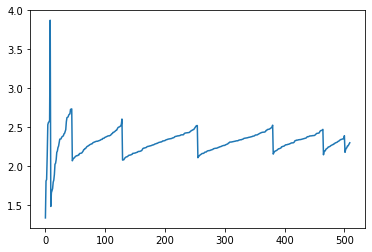

In [120]:
plt.plot(outer_scores['OCV'].reset_index()['OCV'])

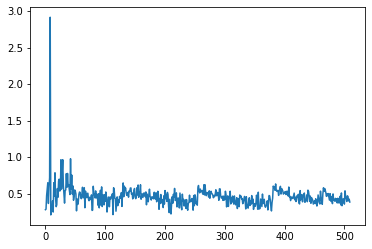

In [121]:
plt.plot(outer_scores['OCVStd'].reset_index()['OCVStd'])

In [122]:
best_terms = outer_scores.iloc[np.argmin(outer_scores['OCV'])]['terms']
best_terms

['Income']

In [123]:
min_scores = pd.DataFrame()
for i in range(1,max(termlengths)):
    min_scores = pd.concat([min_scores,pd.DataFrame(outer_scores.iloc[np.array([len(t) for t in outer_scores['terms']])==i].iloc[np.argmin(outer_scores.iloc[np.array([len(t) for t in outer_scores['terms']])==i]['OCV'])]).T],axis=0)

In [164]:
minterms = []
for i in min_scores.reset_index()['terms'].values:
    minterms.append(i)

In [165]:
minterms

[['Income'],
 ['University', 'Income'],
 ['Infant Mort', 'University', 'Income'],
 ['Infant Mort', 'Traf Deaths', 'University', 'Income'],
 ['Infant Mort', 'White', 'Crime', 'University', 'Income'],
 ['Infant Mort', 'White', 'Crime', 'University', 'Unemployed', 'Income'],
 ['Infant Mort',
  'White',
  'Crime',
  'Doctors',
  'University',
  'Unemployed',
  'Income'],
 ['Infant Mort',
  'White',
  'Crime',
  'Doctors',
  'Traf Deaths',
  'University',
  'Unemployed',
  'Income']]

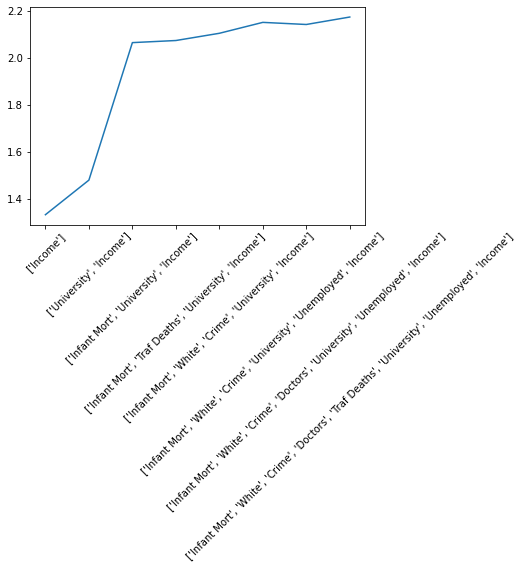

In [174]:
#lt.plot(min_scores.reset_index()['OCV'])
ax= plt.subplot()
#plt.plot(np.array(minterms), min_scores.reset_index()['OCV'])
plt.plot(min_scores.reset_index()['OCV'])
plt.xticks(range(0,len(min_scores)),minterms, rotation=45)
# Function to avoid overlapping

#plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# Display Chart

plt.show()


In [125]:
zca = ZCA()
#zca.fit(X[best_terms])
final_gam = LinearGAM().fit(zca.fit_transform(X[best_terms]),y)

In [126]:
final_gam.statistics_

{'n_samples': 50,
 'm_features': 1,
 'edof_per_coef': array([8.17818277e-01, 2.35044066e-01, 2.69002686e-01, 5.52321999e-01,
        3.37941714e-01, 5.42949551e-01, 4.89487050e-01, 5.90511095e-01,
        4.49035469e-01, 2.30135450e-01, 6.74121155e-01, 4.39241231e-01,
        2.25092319e-01, 4.59224498e-01, 3.84804845e-01, 3.30181379e-01,
        4.88178774e-01, 4.28807304e-01, 6.25072436e-01, 1.75458329e-03,
        2.87106720e-24]),
 'edof': 8.5707258798464,
 'scale': 2.131342151550498,
 'cov': array([[ 2.11849338e+00,  1.03906336e+00,  8.27256391e-02,
         -3.80522364e-01, -3.13485336e-01, -1.33466333e-01,
         -8.55982531e-02, -1.17010121e-01, -1.41438776e-01,
         -1.45268527e-01, -1.39044035e-01, -1.40464007e-01,
         -1.59474912e-01, -1.82188602e-01, -1.89712687e-01,
         -1.79110384e-01, -1.64169323e-01, -1.73622036e-01,
         -2.18250331e-01, -2.69832741e-01,  1.07623681e-01],
        [ 1.03906336e+00,  6.41582537e-01,  2.60031559e-01,
         -2.043741

In [127]:
final_gam.coef_

array([ 8.30238742,  6.92406032,  5.79344852,  4.98253528,  3.81146336,
        1.93879594,  1.08139811,  1.08082771,  0.44375646, -0.78254811,
       -0.7186911 , -0.85135375, -0.89133961, -0.98097632, -1.99895074,
       -2.70056134, -2.88305093, -3.13533251, -3.51992829, -3.9441272 ,
       11.95181347])

In [128]:
final_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.5707
Link Function:                     IdentityLink Log Likelihood:                                   -93.5036
Number of Samples:                           50 AIC:                                              206.1486
                                                AICc:                                             211.2803
                                                GCV:                                                3.0573
                                                Scale:                                              2.1313
                                                Pseudo R-Squared:                                   0.7914
Feature Function                  Lam

In [129]:
np.mean(np.abs(final_gam.predict(zca.transform(X[best_terms]))-y.values.ravel()))

1.0781345203274741

In [130]:
prediction_interval = pd.DataFrame(final_gam.prediction_intervals(zca.transform(X[best_terms])),columns=['lower','upper'])
yhat = pd.DataFrame(final_gam.predict(zca.transform(X[best_terms])),columns=['center'])
prediction_set = pd.concat([prediction_interval['lower'],yhat,prediction_interval['upper']],axis=1)
prediction_set.index = y.index
prediction_set.sort_values(kind="quicksort", ascending=True,by='center',inplace=True)
#plt.plot()
#plt.plot(prediction_interval['upper'])
#plt.show()

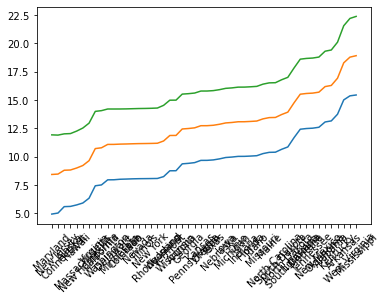

In [131]:
plt.plot(prediction_set['lower'])
plt.plot(prediction_set['center'])
plt.plot(prediction_set['upper'])
plt.xticks(rotation = 45)
plt.show()

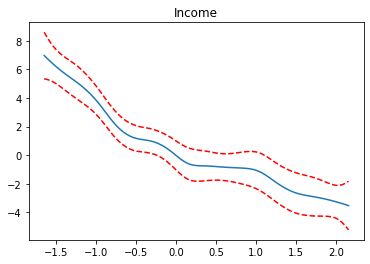

In [132]:
if len(best_terms)>1:
    plt.figure();
    fig, axs = plt.subplots(1,len(best_terms));

    titles = best_terms
    for i, ax in enumerate(axs):
        XX = final_gam.generate_X_grid(term=i)
        ax.plot(XX[:, i], final_gam.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], final_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
        ax.set_title(titles[i]);
else:
    XX = final_gam.generate_X_grid(term=0)
    
    fig, axs = plt.subplots(1,len(best_terms));

    titles = best_terms

    axs.plot(XX[:, 0], final_gam.partial_dependence(term=0, X=XX))
    axs.plot(XX[:, 0], final_gam.partial_dependence(term=0, X=XX, width=.95)[1], c='r', ls='--')
    axs.set_title(best_terms[0]);